References for code: EfficientNet_b4:

https://github.com/enrico310786/brain_tumor_classification/tree/master/config

https://medium.com/@enrico.randellini/image-classification-resnet-vs-efficientnet-vs-efficientnet-v2-vs-compact-convolutional-c205838bbf49

In [1]:
import pandas as pd
import numpy as np

import torch
import pathlib
import random
import cv2
import gc
import sys
import matplotlib.pyplot as plt
from collections import Counter

import solt as sl
import solt.transforms as slt
import sklearn.model_selection as ms
import torch.nn.functional as F

from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torchvision.models as models
import torch.optim as optim

import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import time
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device}')

Using cpu


In [2]:
base_path = "C:/Users/anush/OneDrive/Documents/Sem3/AI in Health Technology/Project/"

In [3]:
def get_train_transform(pretrained=True):
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3),
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        normalize_transform()
    ])
    return train_transform

def get_valid_transform(pretrained=True):
    valid_transform = transforms.Compose([
        transforms.Resize((380, 380)),
        transforms.ToTensor(),
        normalize_transform()
    ])
    return valid_transform

def normalize_transform():
    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
        )
    return normalize

In [9]:
def get_datasets(pretrained=True):
    dataset_train = datasets.ImageFolder(
        base_path+"/data_subset/train", 
        transform=(get_train_transform(pretrained=True))
    )
    dataset_val = datasets.ImageFolder(
        base_path+"/data/valid", 
        transform=(get_valid_transform(pretrained=True))
    )
    dataset_test = datasets.ImageFolder(
        base_path+"/data/test", 
        transform=(get_valid_transform(pretrained=True))
    )
    return dataset_train, dataset_val, dataset_test, dataset_train.classes


def get_data_loaders(dataset_train, dataset_valid, dataset_test, BATCH_SIZE=8):
    train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE)
    valid_loader = DataLoader(dataset_valid, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, valid_loader, test_loader

In [10]:
dataset_train, dataset_valid, dataset_test, dataset_classes = get_datasets(True)
train_loader, valid_loader, test_loader = get_data_loaders(dataset_train, dataset_valid, dataset_test)

In [11]:
len(train_loader)

97

In [12]:
model = models.efficientnet_b4(pretrained=True)
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

#For no finetuning-> Freezing model weights
for params in model.parameters():
    params.requires_grad = False
    
model.classifier = nn.Sequential(nn.Flatten(),
                                 nn.Linear(1792, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.3),
                                 nn.Linear(256, 5))

In [13]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

18,008,909 total parameters.
460,293 training parameters.


In [14]:
# Optimizer:
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Loss function:
criterion = nn.CrossEntropyLoss()

In [15]:
def train(model, trainloader, optimizer, criterion, epochNum):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    list_preds = []
    list_labels = []
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        list_preds.append(preds)
        list_labels.append(labels)
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()
        
    torch.save(model, base_path+f"/efficientnet_b4_dup_subsetData/model_checkpoint_{epochNum}.pt")
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    
    #for balanced accuracy
    list_true = []
    for i in range(len(list_labels)):
        for j in range(0, list_labels[i].shape[0]):
            list_true.append(int(list_labels[i][j]))

    list_pred = []
    for i in range(len(list_preds)):
        for j in range(0, list_preds[i].shape[0]):
            list_pred.append(int(list_preds[i][j]))
            
    balanced_acc = balanced_accuracy_score(list_true, list_pred)
    
    return epoch_loss, epoch_acc, balanced_acc

In [16]:
def validate(model, testloader, criterion):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    list_preds = []
    list_labels = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
            list_preds.append(preds)
            list_labels.append(labels)
            
            
    
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    
    #for balanced accuracy
    list_true = []
    for i in range(len(list_labels)):
        for j in range(0, list_labels[i].shape[0]):
            list_true.append(int(list_labels[i][j]))

    list_pred = []
    for i in range(len(list_preds)):
        for j in range(0, list_preds[i].shape[0]):
            list_pred.append(int(list_preds[i][j]))
            
    balanced_acc = balanced_accuracy_score(list_true, list_pred)
    return epoch_loss, epoch_acc, balanced_acc

In [17]:
epochs = 30
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc, train_bacc = train(model, train_loader, optimizer, criterion, epoch)
    valid_epoch_loss, valid_epoch_acc, valid_bacc = validate(model, valid_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, training BACC: {train_bacc:.3f}")
    print(f"Valid loss: {valid_epoch_loss:.3f}, valid acc: {valid_epoch_acc:.3f}, valid BACC: {valid_bacc:.3f}")
    print('-'*50)
    time.sleep(5)

[INFO]: Epoch 1 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [09:32<00:00,  5.90s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:31<00:00,  3.29s/it]


Training loss: 1.945, training acc: 23.766, training BACC: 0.238
Valid loss: 1.685, valid acc: 6.284, valid BACC: 0.201
--------------------------------------------------
[INFO]: Epoch 2 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [09:21<00:00,  5.78s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:40<00:00,  3.49s/it]


Training loss: 1.693, training acc: 12.597, training BACC: 0.126
Valid loss: 1.671, valid acc: 7.923, valid BACC: 0.201
--------------------------------------------------
[INFO]: Epoch 3 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [09:24<00:00,  5.82s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:49<00:00,  3.69s/it]


Training loss: 1.694, training acc: 6.364, training BACC: 0.064
Valid loss: 1.599, valid acc: 14.481, valid BACC: 0.227
--------------------------------------------------
[INFO]: Epoch 4 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [09:45<00:00,  6.04s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:43<00:00,  3.56s/it]


Training loss: 1.629, training acc: 9.870, training BACC: 0.099
Valid loss: 1.580, valid acc: 35.792, valid BACC: 0.234
--------------------------------------------------
[INFO]: Epoch 5 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [09:40<00:00,  5.98s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:55<00:00,  3.82s/it]


Training loss: 1.619, training acc: 17.792, training BACC: 0.178
Valid loss: 1.866, valid acc: 7.650, valid BACC: 0.200
--------------------------------------------------
[INFO]: Epoch 6 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [09:57<00:00,  6.16s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:53<00:00,  3.77s/it]


Training loss: 1.746, training acc: 11.429, training BACC: 0.114
Valid loss: 1.576, valid acc: 18.579, valid BACC: 0.248
--------------------------------------------------
[INFO]: Epoch 7 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [12:23<00:00,  7.67s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:42<00:00,  4.84s/it]


Training loss: 1.654, training acc: 21.558, training BACC: 0.216
Valid loss: 1.770, valid acc: 9.016, valid BACC: 0.214
--------------------------------------------------
[INFO]: Epoch 8 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:40<00:00,  7.22s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:23<00:00,  4.42s/it]


Training loss: 1.692, training acc: 18.961, training BACC: 0.190
Valid loss: 2.416, valid acc: 8.470, valid BACC: 0.203
--------------------------------------------------
[INFO]: Epoch 9 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:06<00:00,  6.87s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:24<00:00,  4.45s/it]


Training loss: 1.724, training acc: 22.987, training BACC: 0.230
Valid loss: 1.578, valid acc: 19.126, valid BACC: 0.249
--------------------------------------------------
[INFO]: Epoch 10 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:44<00:00,  7.26s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:26<00:00,  4.50s/it]


Training loss: 1.631, training acc: 30.519, training BACC: 0.305
Valid loss: 1.554, valid acc: 21.858, valid BACC: 0.255
--------------------------------------------------
[INFO]: Epoch 11 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:22<00:00,  7.03s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:21<00:00,  4.37s/it]


Training loss: 1.581, training acc: 31.299, training BACC: 0.313
Valid loss: 1.528, valid acc: 27.049, valid BACC: 0.286
--------------------------------------------------
[INFO]: Epoch 12 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:09<00:00,  6.90s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:16<00:00,  4.28s/it]


Training loss: 1.581, training acc: 32.208, training BACC: 0.322
Valid loss: 1.603, valid acc: 15.027, valid BACC: 0.232
--------------------------------------------------
[INFO]: Epoch 13 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:01<00:00,  6.82s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:22<00:00,  4.41s/it]


Training loss: 1.569, training acc: 26.234, training BACC: 0.262
Valid loss: 2.148, valid acc: 11.749, valid BACC: 0.217
--------------------------------------------------
[INFO]: Epoch 14 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:43<00:00,  7.25s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:29<00:00,  4.56s/it]


Training loss: 1.597, training acc: 28.831, training BACC: 0.288
Valid loss: 1.524, valid acc: 23.497, valid BACC: 0.279
--------------------------------------------------
[INFO]: Epoch 15 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:36<00:00,  7.18s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:35<00:00,  4.68s/it]


Training loss: 1.546, training acc: 20.519, training BACC: 0.205
Valid loss: 1.763, valid acc: 16.393, valid BACC: 0.238
--------------------------------------------------
[INFO]: Epoch 16 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:19<00:00,  7.01s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:28<00:00,  4.53s/it]


Training loss: 1.487, training acc: 30.779, training BACC: 0.308
Valid loss: 2.103, valid acc: 17.213, valid BACC: 0.241
--------------------------------------------------
[INFO]: Epoch 17 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:17<00:00,  6.98s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:20<00:00,  4.36s/it]


Training loss: 1.637, training acc: 35.455, training BACC: 0.355
Valid loss: 1.544, valid acc: 23.224, valid BACC: 0.263
--------------------------------------------------
[INFO]: Epoch 18 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:28<00:00,  7.09s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:21<00:00,  4.38s/it]


Training loss: 1.555, training acc: 31.169, training BACC: 0.312
Valid loss: 1.851, valid acc: 20.765, valid BACC: 0.256
--------------------------------------------------
[INFO]: Epoch 19 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:04<00:00,  6.85s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:28<00:00,  4.54s/it]


Training loss: 1.627, training acc: 30.779, training BACC: 0.308
Valid loss: 2.046, valid acc: 15.574, valid BACC: 0.234
--------------------------------------------------
[INFO]: Epoch 20 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:02<00:00,  6.83s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:21<00:00,  4.37s/it]


Training loss: 1.492, training acc: 36.364, training BACC: 0.364
Valid loss: 1.996, valid acc: 18.579, valid BACC: 0.247
--------------------------------------------------
[INFO]: Epoch 21 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:02<00:00,  6.83s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:19<00:00,  4.33s/it]


Training loss: 1.516, training acc: 32.208, training BACC: 0.322
Valid loss: 1.876, valid acc: 22.404, valid BACC: 0.252
--------------------------------------------------
[INFO]: Epoch 22 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:30<00:00,  7.12s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:22<00:00,  4.40s/it]


Training loss: 1.559, training acc: 36.623, training BACC: 0.366
Valid loss: 1.843, valid acc: 16.667, valid BACC: 0.239
--------------------------------------------------
[INFO]: Epoch 23 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:41<00:00,  7.24s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:24<00:00,  4.45s/it]


Training loss: 1.522, training acc: 32.078, training BACC: 0.321
Valid loss: 1.841, valid acc: 19.126, valid BACC: 0.257
--------------------------------------------------
[INFO]: Epoch 24 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:39<00:00,  7.21s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:25<00:00,  4.46s/it]


Training loss: 1.456, training acc: 33.766, training BACC: 0.338
Valid loss: 2.063, valid acc: 16.120, valid BACC: 0.236
--------------------------------------------------
[INFO]: Epoch 25 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:13<00:00,  6.94s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:18<00:00,  4.31s/it]


Training loss: 1.490, training acc: 35.974, training BACC: 0.360
Valid loss: 1.502, valid acc: 30.055, valid BACC: 0.295
--------------------------------------------------
[INFO]: Epoch 26 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:44<00:00,  7.26s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:11<00:00,  4.16s/it]


Training loss: 1.467, training acc: 39.870, training BACC: 0.399
Valid loss: 1.645, valid acc: 25.137, valid BACC: 0.274
--------------------------------------------------
[INFO]: Epoch 27 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:06<00:00,  6.87s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:15<00:00,  4.25s/it]


Training loss: 1.407, training acc: 37.532, training BACC: 0.375
Valid loss: 1.674, valid acc: 24.317, valid BACC: 0.266
--------------------------------------------------
[INFO]: Epoch 28 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:52<00:00,  6.73s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:23<00:00,  4.42s/it]


Training loss: 1.448, training acc: 38.312, training BACC: 0.383
Valid loss: 2.035, valid acc: 21.311, valid BACC: 0.258
--------------------------------------------------
[INFO]: Epoch 29 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:22<00:00,  7.04s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:20<00:00,  4.37s/it]


Training loss: 1.490, training acc: 37.013, training BACC: 0.370
Valid loss: 1.531, valid acc: 30.055, valid BACC: 0.304
--------------------------------------------------
[INFO]: Epoch 30 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:28<00:00,  7.10s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:12<00:00,  4.18s/it]


Training loss: 1.455, training acc: 39.221, training BACC: 0.392
Valid loss: 1.529, valid acc: 30.874, valid BACC: 0.296
--------------------------------------------------


In [18]:
for epoch in range(30, 55):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc, train_bacc = train(model, train_loader, optimizer, criterion, epoch)
    valid_epoch_loss, valid_epoch_acc, valid_bacc = validate(model, valid_loader, criterion)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, training BACC: {train_bacc:.3f}")
    print(f"Valid loss: {valid_epoch_loss:.3f}, valid acc: {valid_epoch_acc:.3f}, valid BACC: {valid_bacc:.3f}")
    print('-'*50)
    time.sleep(5)

[INFO]: Epoch 31 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:03<00:00,  6.84s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:22<00:00,  4.40s/it]


Training loss: 1.376, training acc: 35.455, training BACC: 0.355
Valid loss: 1.573, valid acc: 25.956, valid BACC: 0.267
--------------------------------------------------
[INFO]: Epoch 32 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:43<00:00,  7.25s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:10<00:00,  4.13s/it]


Training loss: 1.373, training acc: 38.701, training BACC: 0.387
Valid loss: 1.470, valid acc: 30.055, valid BACC: 0.286
--------------------------------------------------
[INFO]: Epoch 33 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:07<00:00,  6.88s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:25<00:00,  4.46s/it]


Training loss: 1.383, training acc: 38.442, training BACC: 0.384
Valid loss: 1.462, valid acc: 30.328, valid BACC: 0.301
--------------------------------------------------
[INFO]: Epoch 34 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:11<00:00,  6.92s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:34<00:00,  4.67s/it]


Training loss: 1.423, training acc: 34.416, training BACC: 0.344
Valid loss: 1.425, valid acc: 31.694, valid BACC: 0.287
--------------------------------------------------
[INFO]: Epoch 35 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:12<00:00,  6.93s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:20<00:00,  4.36s/it]


Training loss: 1.363, training acc: 42.208, training BACC: 0.422
Valid loss: 1.525, valid acc: 27.322, valid BACC: 0.271
--------------------------------------------------
[INFO]: Epoch 36 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [11:48<00:00,  7.30s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [03:11<00:00,  4.17s/it]


Training loss: 1.345, training acc: 38.442, training BACC: 0.384
Valid loss: 1.977, valid acc: 22.131, valid BACC: 0.262
--------------------------------------------------
[INFO]: Epoch 37 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:28<00:00,  6.47s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:54<00:00,  3.79s/it]


Training loss: 1.445, training acc: 41.558, training BACC: 0.416
Valid loss: 1.491, valid acc: 27.322, valid BACC: 0.302
--------------------------------------------------
[INFO]: Epoch 38 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:24<00:00,  6.44s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:49<00:00,  3.69s/it]


Training loss: 1.312, training acc: 38.442, training BACC: 0.384
Valid loss: 1.405, valid acc: 31.421, valid BACC: 0.302
--------------------------------------------------
[INFO]: Epoch 39 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:06<00:00,  6.25s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:47<00:00,  3.65s/it]


Training loss: 1.270, training acc: 41.429, training BACC: 0.414
Valid loss: 1.608, valid acc: 23.497, valid BACC: 0.280
--------------------------------------------------
[INFO]: Epoch 40 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:11<00:00,  6.30s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:51<00:00,  3.72s/it]


Training loss: 1.345, training acc: 40.260, training BACC: 0.403
Valid loss: 1.502, valid acc: 26.230, valid BACC: 0.260
--------------------------------------------------
[INFO]: Epoch 41 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:09<00:00,  6.29s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:51<00:00,  3.72s/it]


Training loss: 1.272, training acc: 38.182, training BACC: 0.382
Valid loss: 1.430, valid acc: 28.142, valid BACC: 0.267
--------------------------------------------------
[INFO]: Epoch 42 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:26<00:00,  6.46s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:50<00:00,  3.70s/it]


Training loss: 1.278, training acc: 38.052, training BACC: 0.381
Valid loss: 1.390, valid acc: 30.601, valid BACC: 0.266
--------------------------------------------------
[INFO]: Epoch 43 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [09:58<00:00,  6.17s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:46<00:00,  3.63s/it]


Training loss: 1.241, training acc: 41.558, training BACC: 0.416
Valid loss: 1.599, valid acc: 23.770, valid BACC: 0.252
--------------------------------------------------
[INFO]: Epoch 44 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:10<00:00,  6.29s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:47<00:00,  3.65s/it]


Training loss: 1.369, training acc: 40.649, training BACC: 0.406
Valid loss: 1.614, valid acc: 25.410, valid BACC: 0.258
--------------------------------------------------
[INFO]: Epoch 45 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:29<00:00,  6.49s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:52<00:00,  3.74s/it]


Training loss: 1.257, training acc: 39.221, training BACC: 0.392
Valid loss: 1.683, valid acc: 20.492, valid BACC: 0.220
--------------------------------------------------
[INFO]: Epoch 46 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:14<00:00,  6.33s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:59<00:00,  3.91s/it]


Training loss: 1.244, training acc: 38.701, training BACC: 0.387
Valid loss: 1.722, valid acc: 27.322, valid BACC: 0.299
--------------------------------------------------
[INFO]: Epoch 47 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:23<00:00,  6.43s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:52<00:00,  3.76s/it]


Training loss: 1.204, training acc: 43.636, training BACC: 0.436
Valid loss: 1.813, valid acc: 22.404, valid BACC: 0.263
--------------------------------------------------
[INFO]: Epoch 48 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:13<00:00,  6.32s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:48<00:00,  3.66s/it]


Training loss: 1.269, training acc: 40.130, training BACC: 0.401
Valid loss: 1.782, valid acc: 26.503, valid BACC: 0.262
--------------------------------------------------
[INFO]: Epoch 49 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:04<00:00,  6.23s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:47<00:00,  3.65s/it]


Training loss: 1.205, training acc: 44.545, training BACC: 0.445
Valid loss: 2.157, valid acc: 21.858, valid BACC: 0.256
--------------------------------------------------
[INFO]: Epoch 50 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:23<00:00,  6.42s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:46<00:00,  3.63s/it]


Training loss: 1.251, training acc: 42.597, training BACC: 0.426
Valid loss: 1.866, valid acc: 23.224, valid BACC: 0.268
--------------------------------------------------
[INFO]: Epoch 51 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:00<00:00,  6.19s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:48<00:00,  3.66s/it]


Training loss: 1.175, training acc: 44.286, training BACC: 0.443
Valid loss: 2.137, valid acc: 24.590, valid BACC: 0.261
--------------------------------------------------
[INFO]: Epoch 52 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:08<00:00,  6.27s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:48<00:00,  3.66s/it]


Training loss: 1.294, training acc: 46.883, training BACC: 0.469
Valid loss: 2.048, valid acc: 25.137, valid BACC: 0.277
--------------------------------------------------
[INFO]: Epoch 53 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:13<00:00,  6.33s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:49<00:00,  3.68s/it]


Training loss: 1.198, training acc: 41.818, training BACC: 0.418
Valid loss: 1.919, valid acc: 22.951, valid BACC: 0.253
--------------------------------------------------
[INFO]: Epoch 54 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:50<00:00,  6.71s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:56<00:00,  3.84s/it]


Training loss: 1.171, training acc: 43.896, training BACC: 0.439
Valid loss: 1.819, valid acc: 24.590, valid BACC: 0.277
--------------------------------------------------
[INFO]: Epoch 55 of 30
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 97/97 [10:17<00:00,  6.36s/it]


Validation


100%|██████████████████████████████████████████████████████████████████████████████████| 46/46 [02:47<00:00,  3.65s/it]


Training loss: 1.152, training acc: 45.584, training BACC: 0.456
Valid loss: 1.793, valid acc: 23.770, valid BACC: 0.245
--------------------------------------------------


In [21]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, pretrained):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
    plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(base_path + f"/outputs/accuracy_pretrained_{pretrained}.png")
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
    plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(base_path + f"/outputs/loss_pretrained_{pretrained}.png")

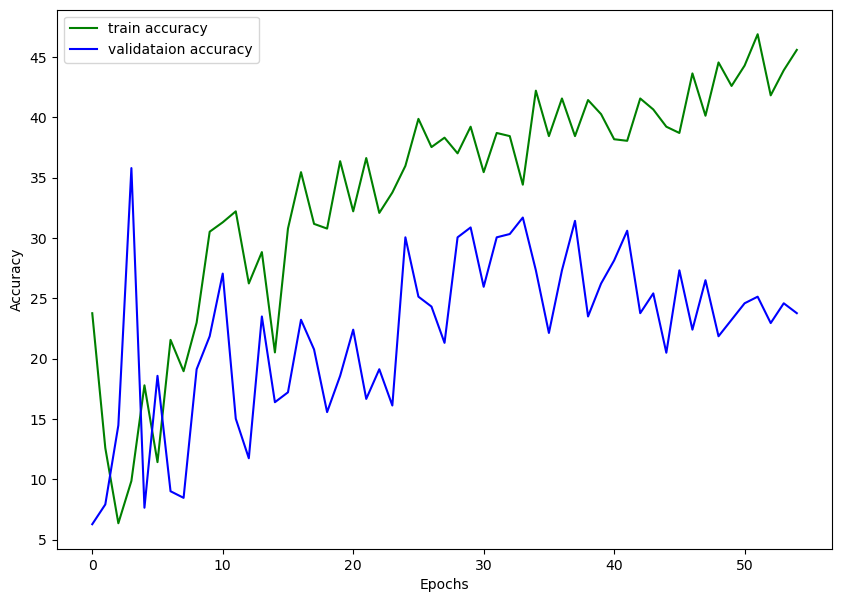

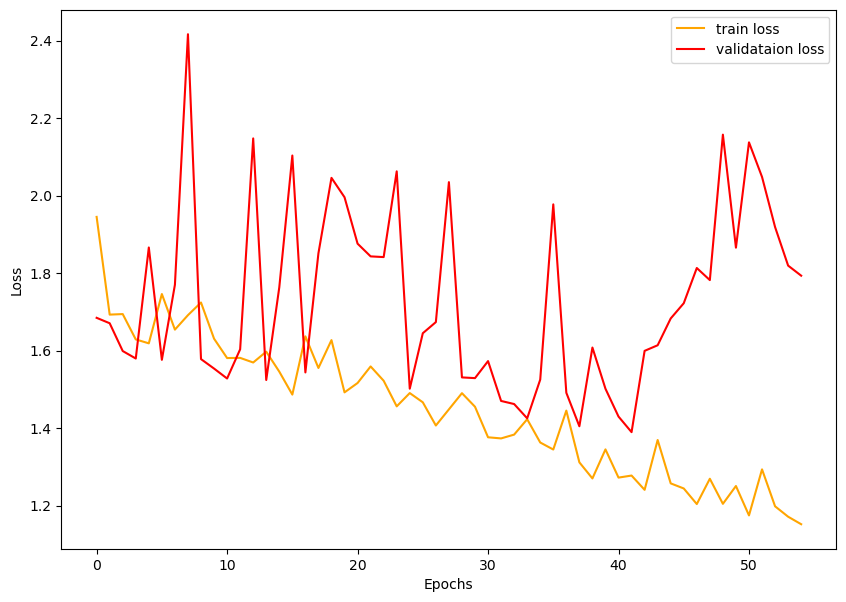

In [22]:
save_plots(train_acc, valid_acc, train_loss, valid_loss, "efficientnet_b4_dup_subsetData")